#### Install necessary libraries

%pip install cvxpy
%pip install pandas
%pip install yfinance
%pip install matplotlib
%pip install seaborn

#### Import below libraries

In [112]:
import yfinance as yf
import pandas as pd
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt
import datetime
import matplotlib.dates as mdates
import seaborn as sns

## 1. Download quotes for US listed companies:
- InterActiveCorp,
- LiveRamp Holding, Inc.,
- Olimpic Steel, Inc.,
- Zimmer Biomet Holdings, Inc.,
- AptarGroup, Inc.,
- MetLife, Inc..

We collect the necessary company data using the yfinance library.
The `"Ticker"` company abbreviations are as follows:
- `IAC` InterActiveCorp,

- `RAMP` LiveRamp Holding, Inc.,

- `ZEUS` Olimpic Steel, Inc.,

- `ZBH` Zimmer Biomet Holdings, Inc.,

- `ATR` AptarGroup, Inc.,

- `MET` MetLife, Inc..


In [113]:
# Using the bracket ["Close"] we only retrieve the last values ​​of a given day.
company_data = yf.download(['IAC', 'RAMP', 'ZEUS', 'ZBH', 'ATR', 'MET'], start='2004-01-01', end='2018-01-01')['Close'] 
# We make sure that the index numbering is in the correct order.
company_data.reset_index(inplace=True)
company_data["Date"] = pd.to_datetime(company_data["Date"]).dt.tz_localize(None).dt.date

[*********************100%***********************]  6 of 6 completed


In [114]:
# We do the same for the zloty to dollar exchange rate.
currency = yf.Ticker("PLN=X")
currency = currency.history(start='2004-01-01', end='2018-01-01')
# We only select the "Close" column because that's what we're interested in.
currency = currency['Close'] 
# We make sure that the index numbering is in the correct order, just like in the case of listed companies.
currency = currency.reset_index()
currency["Date"] = pd.to_datetime(currency["Date"]).dt.tz_localize(None).dt.date
# We change the name of the "Close" column to a more understandable one "PLN-USD".
currency = currency.rename(columns={"Close":"PLN-USD"})

In [115]:
# We check if we are missing data for the entire period for both data sets. If in the "listed companies" or "currency" set
# there is missing data for a specific date, we get rid of it because we cannot obtain valuable data in the process of currency conversion
# of shares in our portfolio.
company_data_unique_dates = company_data['Date'].unique()
currency_unique_dates = currency['Date'].unique()

missing_dates_company_data = set(company_data_unique_dates) - set(currency_unique_dates)
missing_dates_currency = set(currency_unique_dates) - set(company_data_unique_dates)
currency = currency[~currency['Date'].isin(missing_dates_company_data) & 
                ~currency['Date'].isin(missing_dates_currency)].reset_index(drop=True)
company_data = company_data[~company_data['Date'].isin(missing_dates_company_data) & 
                                  ~company_data['Date'].isin(missing_dates_currency)].reset_index(drop=True)

# We're getting rid of missing, incompatible data. There are only 30 of them over 14 years.

In [116]:
company_data

Ticker,Date,ATR,IAC,MET,RAMP,ZBH,ZEUS
0,2004-01-02,19.280001,7.025336,29.910873,18.809999,67.961166,8.110000
1,2004-01-05,19.799999,7.173193,30.213903,19.000000,67.349518,7.350000
2,2004-01-06,19.895000,7.033785,29.964350,19.000000,67.019417,7.880000
3,2004-01-07,19.815001,6.970418,29.679144,19.150000,67.766991,7.240000
4,2004-01-08,19.924999,6.898601,29.483067,18.920000,69.077667,7.380000
...,...,...,...,...,...,...,...
3490,2017-12-22,85.900002,27.661333,50.759998,27.549999,116.621361,22.150000
3491,2017-12-26,85.389999,27.081833,50.669998,27.430000,116.466019,22.200001
3492,2017-12-27,85.620003,27.116690,50.750000,27.370001,116.640778,21.830000
3493,2017-12-28,86.750000,26.850904,50.869999,27.490000,118.203880,21.700001


In [117]:
currency

,Date,PLN-USD
0,2004-01-02,3.73590
1,2004-01-05,3.68360
2,2004-01-06,3.64570
3,2004-01-07,3.68360
4,2004-01-08,3.67860
...,...,...
3490,2017-12-22,3.53896
3491,2017-12-26,3.53175
3492,2017-12-27,3.53931
3493,2017-12-28,3.51974


#### At this point both tables are the same size. That is 3495 rows and corresponding dates.

## 2. Calculate the logarithmic rates of return for each of the companies. Which company had the highest average rate of return? Which had the smallest standard deviation? Which had the best Sharpe ratio?

To do this, we create a new DataFrame using the `Pandas` Library. We separate both sets for clarity.

In [118]:
logarithmic_rates_of_return = pd.DataFrame({
    "Date": company_data["Date"],
    "Ln ATR": np.log(company_data["ATR"].pct_change() + 1),
    "Ln IAC": np.log(company_data["IAC"].pct_change() + 1),
    "Ln MET": np.log(company_data["MET"].pct_change() + 1),
    "Ln RAMP": np.log(company_data["RAMP"].pct_change() + 1),
    "Ln ZBH": np.log(company_data["ZBH"].pct_change() + 1),
    "Ln ZEUS": np.log(company_data["ZEUS"].pct_change() + 1)
})
logarithmic_rates_of_return

,Date,Ln ATR,Ln IAC,Ln MET,Ln RAMP,Ln ZBH,Ln ZEUS
0,2004-01-02,NaN,NaN,NaN,NaN,NaN,NaN
1,2004-01-05,0.026614,0.020828,0.010080,0.010050,-0.009041,-0.098398
2,2004-01-06,0.004787,-0.019626,-0.008294,0.000000,-0.004913,0.069628
3,2004-01-07,-0.004029,-0.009050,-0.009564,0.007864,0.011093,-0.084707
4,2004-01-08,0.005536,-0.010357,-0.006628,-0.012083,0.019156,0.019152
...,...,...,...,...,...,...,...
3490,2017-12-22,0.001631,-0.000236,-0.005305,0.001817,0.001416,-0.016566
3491,2017-12-26,-0.005955,-0.021172,-0.001775,-0.004365,-0.001333,0.002255
3492,2017-12-27,0.002690,0.001286,0.001578,-0.002190,0.001499,-0.016807
3493,2017-12-28,0.013111,-0.009850,0.002362,0.004375,0.013312,-0.005973


### Statystyki spółek

In [119]:
# We create the functions we need to calculate the annual mean, median, standard deviation, and Sharpe ratio.
def mean(x):
    return x.mean() * 250

def mediane(x):
    return x.median() * 250

def standard_deviation(x):
    return x.std() * np.sqrt(250) 

def sharp(x):
    return (mean(x) - rf) / standard_deviation(x)

rf = 0.02 # We assume the following average risk-free rate of return.

# We create the "average" table using the .agg() function from the Pandas library, which # accumulates data simultaneously using the functions listed in brackets [].
means = logarithmic_rates_of_return.agg({
    "Ln ATR": [mean, mediane, standard_deviation, sharp],
    "Ln IAC": [mean, mediane, standard_deviation, sharp],
    "Ln MET": [mean, mediane, standard_deviation, sharp],
    "Ln RAMP": [mean, mediane, standard_deviation, sharp],
    "Ln ZBH": [mean, mediane, standard_deviation, sharp],
    "Ln ZEUS": [mean, mediane, standard_deviation, sharp],}).T
# We replace the column names with more readable ones.
means.columns = ['mean', 'mediane', 'standard_deviation', 'sharp']
means

,mean,mediane,standard_deviation,sharp
Ln ATR,0.107222,0.156010,0.237293,0.367569
Ln IAC,0.095369,0.000000,0.290860,0.259125
Ln MET,0.037560,0.049795,0.435494,0.040322
Ln RAMP,0.027331,0.000000,0.387938,0.018897
Ln ZBH,0.038964,0.116603,0.264455,0.071711
Ln ZEUS,0.069726,0.000000,0.590566,0.084200


### Wskazujemy interesujące nas wartosci.

In [120]:
results = means.agg(
    najwieksza_srednia = ('mean', "max"),                     
    najmniejsze_odchylenie = ('standard_deviation', "min"),
    najwiekszy_sharp = ('sharp', "max"))

results.index = ['the highest mean', "smallest standard deviation", "the highest sharpness index"]
results.replace({np.nan: "-"}) # We replace each NaN character with '-' using numpy.nan and the replace function
# for better readability
# All results belong to ATR

,mean,standard_deviation,sharp
the highest mean,0.107222,-,-
smallest standard deviation,-,0.237293,-
the highest sharpness index,-,-,0.367569


## 3. Select weights for each stock in the portfolio. Calculate the portfolio's rate of return. Compare the following portfolio statistics to their individual stock counterparts:
- Cumulative rate of return,
- Sharpe ratio,
- 95% percentile,
- Skewness.

#### We start by calculating the covariance matrix.

In [121]:
covariances = logarithmic_rates_of_return[["Ln ATR", "Ln IAC", "Ln MET", "Ln RAMP", "Ln ZBH", "Ln ZEUS"]].cov()
covariances

,Ln ATR,Ln IAC,Ln MET,Ln RAMP,Ln ZBH,Ln ZEUS
Ln ATR,0.000225,0.000098,0.000197,0.000147,0.000093,0.000223
Ln IAC,0.000098,0.000338,0.000179,0.000143,0.000088,0.000173
Ln MET,0.000197,0.000179,0.000759,0.000284,0.000183,0.000400
Ln RAMP,0.000147,0.000143,0.000284,0.000602,0.000124,0.000283
Ln ZBH,0.000093,0.000088,0.000183,0.000124,0.000280,0.000187
Ln ZEUS,0.000223,0.000173,0.000400,0.000283,0.000187,0.001395


### Using the `cvxpy` library we calculate the optimal weights for our portfolio.

In [122]:
length = covariances.shape[0] # We create a variable that returns the row/column length.
initial_weights = np.ones(length) / length  # We create initial weights, all of which are equal and sum to 1.

# We write down the constraints for the minimization problem. 
weights= cp.Variable(length)
risk = cp.quad_form(weights, covariances)
ograniczenia = [cp.sum(weights) == 1, weights>= 0]  # Weights must sum to 1

# We define the objective function as a risk minimization problem.
cel = cp.Minimize(risk)
problem = cp.Problem(cel, ograniczenia)

# The function below runs the solver.
problem.solve()

# We get the result as a weight vector.
optimal_weights= abs(weights.value)

print("weights calculated based on the covariance matrix:\n", 
      np.array([company_data.columns[1:].values, np.round(optimal_weights, 6)]).T)

weights calculated based on the covariance matrix:
 [['ATR' 0.423921]
 ['IAC' 0.231136]
 ['MET' 0.0]
 ['RAMP' 0.028185]
 ['ZBH' 0.316757]
 ['ZEUS' 0.0]]


### Portfolio Return Rate

In [123]:
means_rate_of_return = means[['mean'][0]].to_list()
portfolio_shares = []

for i in range(np.size(optimal_weights)):
    portfolio_shares.append(means_rate_of_return[i] * optimal_weights[i])

portfolio_shares = np.array(portfolio_shares)
print("We receive the following portfolio shares for each company:\n", 
      np.array([company_data.columns[1:].values, np.round(portfolio_shares, 6)]).T)
portfolio_rate_of_return = sum(portfolio_shares)
print("\nThe portfolio rate of return is =", portfolio_rate_of_return)

We receive the following portfolio shares for each company:
 [['ATR' 0.045454]
 ['IAC' 0.022043]
 ['MET' 0.0]
 ['RAMP' 0.00077]
 ['ZBH' 0.012342]
 ['ZEUS' 0.0]]

The portfolio rate of return is = 0.08060926412269045


### Portfolio Deviation to Sharpe

In [124]:
# '@' is the matrix multiplication symbol
# '.T' after the optimal_weights variable means transposing the matrix (in this case the weight vector).
portfolio_deviation = np.sqrt(optimal_weights @ covariances @ optimal_weights.T)
print("portfolio standard deviation =", portfolio_deviation)

portfolio standard deviation = 0.012312506494508619


### Sharpe ratio for investment portfolio

In [125]:
counted_sharp = (portfolio_rate_of_return - rf) / portfolio_deviation 
print("Sharpe ratio=", counted_sharp)

Sharpe ratio= 4.922577230698087


### Daily Portfolio Return

In [126]:
cumulative_rates_of_return = pd.DataFrame({
    "Date":company_data["Date"],
    "Sharpe ratio":logarithmic_rates_of_return[["Ln ATR", "Ln IAC", "Ln MET", "Ln RAMP", "Ln ZBH", "Ln ZEUS"]] @ 
    optimal_weights})


### Total Portfolio Returns

In [127]:
portfolio_rate_sum = cumulative_rates_of_return[["Sharpe ratio"]].sum()
print("Total Portfolio Returns =",portfolio_rate_sum)

Total Portfolio Returns = Sharpe ratio    1.126595
dtype: float64


### We assume the "Cumulative rate of return" abbreviation for a given company as CRoR <company abbreviation>
### For the DataFrame cumulative_rate_of_return we add the following columns:

In [128]:
cumulative_rates_of_return["CRoR portfela"] = (1 + cumulative_rates_of_return.fillna(0)["Sharpe ratio"]).cumprod()*100
cumulative_rates_of_return['CRoR ATR'] = (1 + logarithmic_rates_of_return.fillna(0)["Ln ATR"]).cumprod()*100
cumulative_rates_of_return['CRoR IAC'] = (1 + logarithmic_rates_of_return.fillna(0)["Ln IAC"]).cumprod()*100
cumulative_rates_of_return['CRoR MET'] = (1 + logarithmic_rates_of_return.fillna(0)["Ln MET"]).cumprod()*100
cumulative_rates_of_return['CRoR RAMP'] = (1 + logarithmic_rates_of_return.fillna(0)["Ln RAMP"]).cumprod()*100
cumulative_rates_of_return['CRoR ZBH'] = (1 + logarithmic_rates_of_return.fillna(0)["Ln ZBH"]).cumprod()*100
cumulative_rates_of_return['CRoR ZEUS'] = (1 + logarithmic_rates_of_return.fillna(0)["Ln ZEUS"]).cumprod()*100
cumulative_rates_of_return

,Date,Sharpe ratio,CRoR portfela,CRoR ATR,CRoR IAC,CRoR MET,CRoR RAMP,CRoR ZBH,CRoR ZEUS
0,2004-01-02,NaN,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
1,2004-01-05,0.013516,101.351569,102.661357,102.082787,101.008012,101.005036,99.095928,90.160247
2,2004-01-06,-0.004063,100.939730,103.152753,100.079317,100.170266,101.005036,98.609034,96.437891
3,2004-01-07,-0.000064,100.933227,102.737129,99.173623,99.212261,101.799311,99.702888,88.268951
4,2004-01-08,0.005680,101.506563,103.305874,98.146527,98.554634,100.569257,101.612823,89.959520
...,...,...,...,...,...,...,...,...,...
3490,2017-12-22,0.001137,237.849460,300.264672,218.274452,44.032763,50.280968,104.791073,23.558732
3491,2017-12-26,-0.007963,235.955384,298.476639,213.653060,43.954621,50.061482,104.651396,23.611853
3492,2017-12-27,0.001851,236.392102,299.279524,213.927874,44.023965,49.951859,104.808309,23.215005
3493,2017-12-28,0.007622,238.193776,303.203523,211.820709,44.127938,50.170385,106.203517,23.076345


### Skewness
We use the .skew() function from the `Pandas` library to calculate skewness

In [129]:
print("skewnes")
skewnes = logarithmic_rates_of_return[["Ln ATR", "Ln IAC", "Ln MET", "Ln RAMP", "Ln ZBH", "Ln ZEUS"]].skew()
skewnes

skewnes


Ln ATR    -0.248994
Ln IAC     0.245668
Ln MET    -0.424824
Ln RAMP   -0.644189
Ln ZBH    -0.697867
Ln ZEUS   -0.036373
dtype: float64

### 95th percentile
We use the .quantile(q=0.95) function from the `Pandas` library to calculate the 95th percentile.

In [130]:
print("95 percentile")
percentile = logarithmic_rates_of_return[["Ln ATR", "Ln IAC", "Ln MET", "Ln RAMP", "Ln ZBH", "Ln ZEUS"]].quantile(q=0.95)
percentile

95 percentile


Ln ATR     0.022998
Ln IAC     0.028161
Ln MET     0.033786
Ln RAMP    0.034535
Ln ZBH     0.023527
Ln ZEUS    0.058012
Name: 0.95, dtype: float64

## 4. Present two graphs that describe the performance of the portfolio and individual stocks

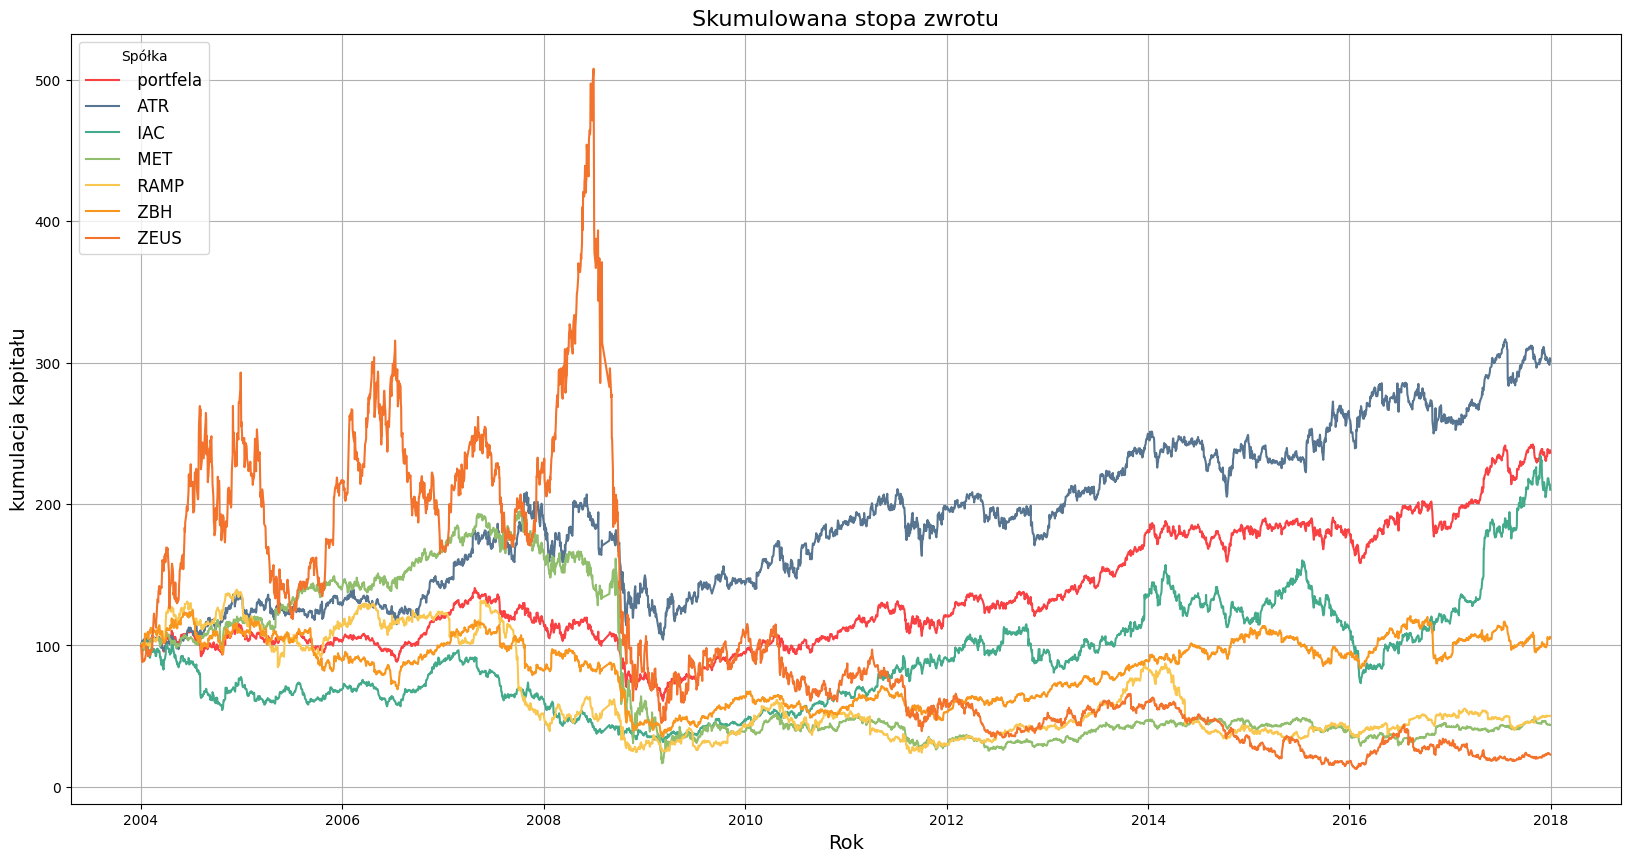

In [131]:
x = cumulative_rates_of_return["Date"]
y = ["CRoR portfela","CRoR ATR","CRoR IAC","CRoR MET","CRoR RAMP","CRoR ZBH","CRoR ZEUS"]
colors=["#f94144","#f3722c","#f8961e","#f9c74f","#90be6d","#43aa8b","#577590"]
plt.figure(figsize=(20, 10))
plt.grid()
for company in range(len(y)):
    plt.plot(x, cumulative_rates_of_return[[y[company]]], label=y[company].replace("CRoR "," "), color=colors[-company])
plt.legend(loc='upper left',title="Spółka", fontsize=12)
plt.xlabel("Rok", fontsize=14)
plt.ylabel("kumulacja kapitału", fontsize=14)
plt.title("Skumulowana stopa zwrotu", fontsize=16)
# plt.autoscale(axis="x", tight=True)
# plt.savefig('wykres1.png',  bbox_inches='tight', pad_inches=0.1)
plt.show()

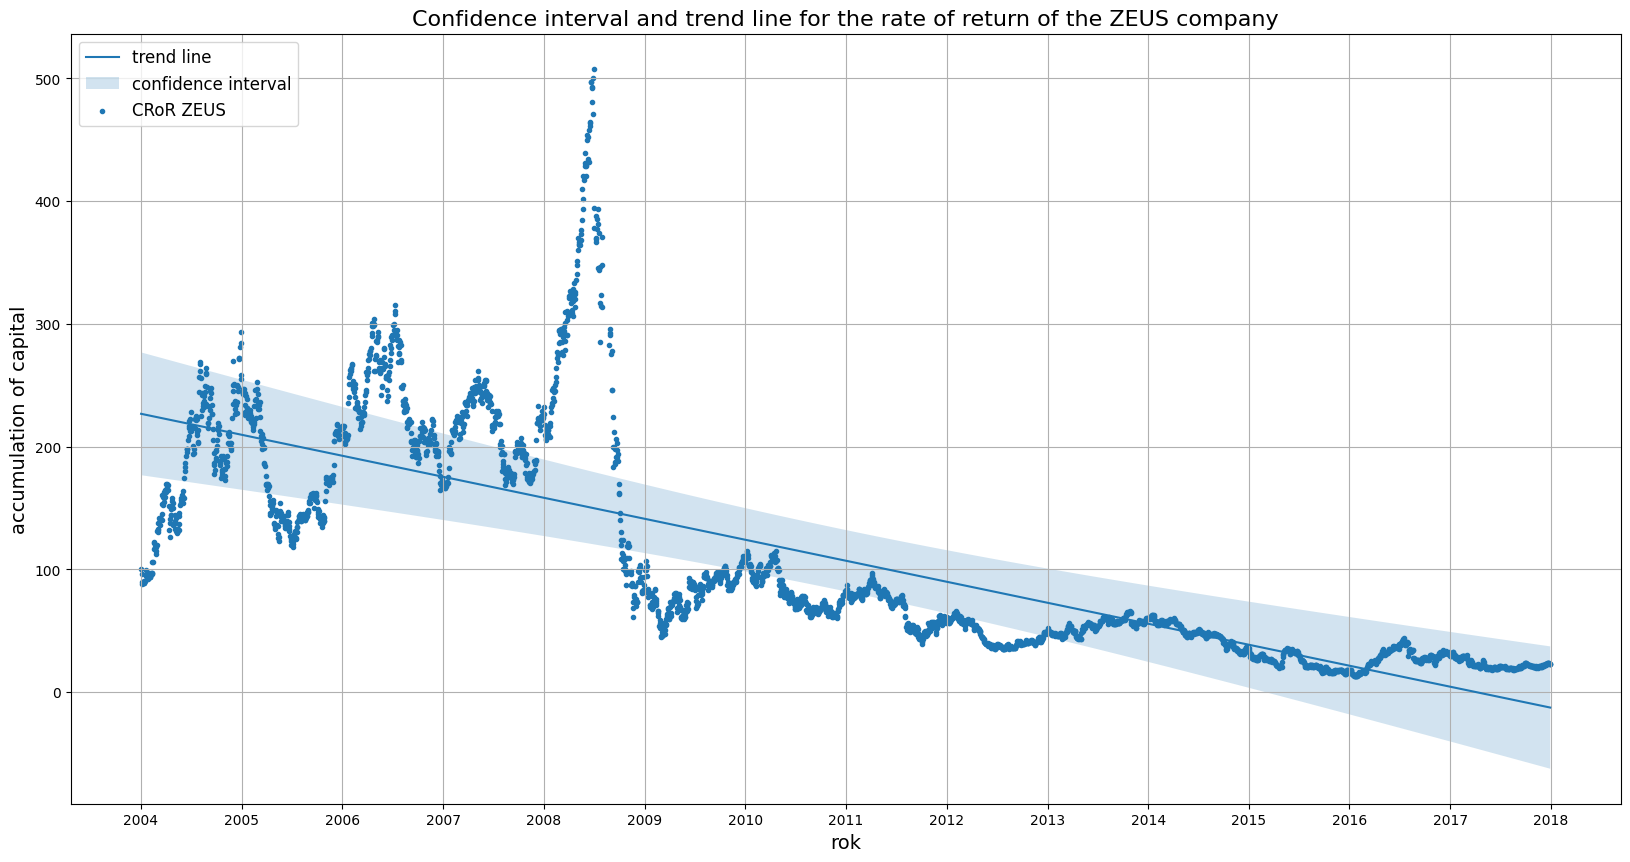

In [132]:
# To create a confidence interval graph, we can convert our data
# to numeric values ​​to perform a few auxiliary operations on them.
x = np.array([date.toordinal() - datetime.datetime(1970, 1, 1).toordinal() for date in cumulative_rates_of_return["Date"]])
y = cumulative_rates_of_return["CRoR ZEUS"].values

a, b = np.polyfit(x, y, deg=1)
y_est = a * x + b
y_err = x.std() * np.sqrt(1/len(x) + (x - x.mean())**2 / np.sum((x - x.mean())**2))

fig, ax = plt.subplots(figsize=(20, 10))

plt.grid()
ax.plot(x, y_est, label="trend line")
ax.fill_between(x, y_est - y_err, y_est + y_err, alpha=0.2, label="confidence interval")
ax.scatter(x, y, marker='.', color='Tab:blue', label="CRoR ZEUS")
plt.xlabel("rok", fontsize=14)
plt.ylabel("accumulation of capital", fontsize=14)
plt.title("Confidence interval and trend line for the rate of return of the ZEUS company", fontsize=16)
plt.legend(loc=2, fontsize=12)

x_dates = mdates.num2date(x + datetime.datetime(1970, 1, 1).toordinal())
date_format = mdates.DateFormatter("%Y")
ax.xaxis.set_major_formatter(date_format)
ax.xaxis.set_major_locator(mdates.YearLocator())

plt.show()

# Advanced Part

## 5. Download the USDPLN rate, match it to the quotes of the companies in the portfolio. Calculate the rates of return in PLN for the portfolio and individual companies. Compare the statistics of the portfolio and company quotes in USD and PLN.

We have moved the data collection stage to the very beginning to organize the data from the start. This will avoid any inconsistencies and differences in the number of data.

In [133]:
currency

,Date,PLN-USD
0,2004-01-02,3.73590
1,2004-01-05,3.68360
2,2004-01-06,3.64570
3,2004-01-07,3.68360
4,2004-01-08,3.67860
...,...,...
3490,2017-12-22,3.53896
3491,2017-12-26,3.53175
3492,2017-12-27,3.53931
3493,2017-12-28,3.51974


In [134]:
# We create a new DataFrame for the converted values ​​of company shares.
converted_stocks = pd.DataFrame(company_data["Date"])

for company in company_data.columns[1:]:
    converted_stocks[str(company)] = company_data[company].values * currency["PLN-USD"].values

converted_stocks

,Date,ATR,IAC,MET,RAMP,ZBH,ZEUS
0,2004-01-02,72.028153,26.245951,111.744030,70.272276,253.896116,30.298147
1,2004-01-05,72.935276,26.423173,111.295933,69.988399,248.088680,27.074459
2,2004-01-06,72.531203,25.643069,109.241029,69.268300,244.332686,28.728116
3,2004-01-07,72.990535,25.676231,109.326093,70.540938,249.626483,26.669263
4,2004-01-08,73.296104,25.377194,108.456411,69.599114,254.109112,27.148069
...,...,...,...,...,...,...,...
3490,2017-12-22,303.996668,97.892351,179.637603,97.498345,412.718329,78.387962
3491,2017-12-26,301.576127,95.646262,178.953764,96.875903,411.328857,78.404852
3492,2017-12-27,303.035730,95.974370,179.619981,96.870917,412.827868,77.263137
3493,2017-12-28,305.337454,94.508205,179.049175,96.757655,416.046938,76.378363


In [135]:
logarithmic_rates_of_return_converted = pd.DataFrame({
    "Date": converted_stocks["Date"],
    "Ln ATR": np.log(converted_stocks["ATR"].pct_change() + 1),
    "Ln IAC": np.log(converted_stocks["IAC"].pct_change() + 1),
    "Ln MET": np.log(converted_stocks["MET"].pct_change() + 1),
    "Ln RAMP": np.log(converted_stocks["RAMP"].pct_change() + 1),
    "Ln ZBH": np.log(converted_stocks["ZBH"].pct_change() + 1),
    "Ln ZEUS": np.log(converted_stocks["ZEUS"].pct_change() + 1)
})
logarithmic_rates_of_return_converted

,Date,Ln ATR,Ln IAC,Ln MET,Ln RAMP,Ln ZBH,Ln ZEUS
0,2004-01-02,NaN,NaN,NaN,NaN,NaN,NaN
1,2004-01-05,0.012515,0.006730,-0.004018,-0.004048,-0.023139,-0.112496
2,2004-01-06,-0.005556,-0.029968,-0.018636,-0.010342,-0.015255,0.059285
3,2004-01-07,0.006313,0.001292,0.000778,0.018206,0.021435,-0.074365
4,2004-01-08,0.004178,-0.011715,-0.007987,-0.013441,0.017798,0.017794
...,...,...,...,...,...,...,...
3490,2017-12-22,0.001337,-0.000530,-0.005599,0.001523,0.001122,-0.016860
3491,2017-12-26,-0.007994,-0.023212,-0.003814,-0.006405,-0.003372,0.000215
3492,2017-12-27,0.004828,0.003425,0.003716,-0.000051,0.003638,-0.014669
3493,2017-12-28,0.007567,-0.015395,-0.003183,-0.001170,0.007767,-0.011518


### Portfolio company statistics in PLN

In [136]:
means_converted = logarithmic_rates_of_return_converted.agg({
    "Ln ATR": [mean, mediane, standard_deviation, sharp],
    "Ln IAC": [mean, mediane, standard_deviation, sharp],
    "Ln MET": [mean, mediane, standard_deviation, sharp],
    "Ln RAMP": [mean, mediane, standard_deviation, sharp],
    "Ln ZBH": [mean, mediane, standard_deviation, sharp],
    "Ln ZEUS": [mean, mediane, standard_deviation, sharp],
}).T
means_converted.columns = ['average rate of return', 'mediane', 'standard deviation', 'Sharp']
means_converted

,average rate of return,mediane,standard deviation,Sharp
Ln ATR,0.102534,0.077960,0.257490,0.320533
Ln IAC,0.090681,-0.018404,0.318624,0.221833
Ln MET,0.032873,0.029441,0.427748,0.030094
Ln RAMP,0.022643,-0.191666,0.399055,0.006624
Ln ZBH,0.034277,0.053731,0.285142,0.050069
Ln ZEUS,0.065039,0.019356,0.577023,0.078053


In [137]:
wyniki_przewalutowane = means_converted.agg(
    highest_mean = ('average rate of return', "max"),                     
    lowest_standard_deviation = ('standard deviation', "min"),
    highest_sharp = ('Sharp', "max"))

wyniki_przewalutowane.index = ['the highest mean', "lowest standard deviation", "the highest sharp"]
wyniki_przewalutowane.replace({np.nan:"-"}) # WE replace each NaN character with '-' using numpy.nan and the replace function
# All results belong to ATR

,average rate of return,standard deviation,Sharp
the highest mean,0.102534,-,-
lowest standard deviation,-,0.25749,-
the highest sharp,-,-,0.320533


### covariances

In [138]:
covariances_converted = logarithmic_rates_of_return_converted[
    ["Ln ATR", "Ln IAC", "Ln MET", "Ln RAMP", "Ln ZBH", "Ln ZEUS"]].cov()
covariances_converted

,Ln ATR,Ln IAC,Ln MET,Ln RAMP,Ln ZBH,Ln ZEUS
Ln ATR,0.000265,0.000152,0.000204,0.000185,0.000135,0.000212
Ln IAC,0.000152,0.000406,0.000200,0.000194,0.000144,0.000175
Ln MET,0.000204,0.000200,0.000732,0.000288,0.000193,0.000355
Ln RAMP,0.000185,0.000194,0.000288,0.000637,0.000164,0.000269
Ln ZBH,0.000135,0.000144,0.000193,0.000164,0.000325,0.000178
Ln ZEUS,0.000212,0.000175,0.000355,0.000269,0.000178,0.001332


In [139]:
average_rates_of_return = means_converted[['average rate of return'][0]].to_list()
portfolio_shares = []

for i in range(np.size(optimal_weights)):
    portfolio_shares.append(average_rates_of_return[i] * optimal_weights[i])

print("Shares in the converted portfolio for each company:\n", np.round(portfolio_shares,6))
portfolio_rate_of_return_converted = sum(portfolio_shares)
print("Rate of return on the converted portfolio=", np.round(portfolio_rate_of_return_converted, 6))
portfolio_shares = np.array(portfolio_shares)

Shares in the converted portfolio for each company:
 [0.043466 0.02096  0.       0.000638 0.010857 0.      ]
Rate of return on the converted portfolio= 0.075922


### Portfolio Deviation

In [140]:
portfolio_deviation_converted = np.sqrt(optimal_weights @ covariances_converted @ optimal_weights.T)
print("Deviation of the converted portfolio=", portfolio_deviation_converted)

Deviation of the converted portfolio= 0.014127278944818243


### Sharpe ratio

In [141]:
counted_sharp_converted = (portfolio_rate_of_return_converted - rf) / portfolio_deviation_converted
print("Sharpe ratio for the converted portfolio =", counted_sharp_converted)

Sharpe ratio for the converted portfolio = 3.958429358013736


### Portfolio Return Rate

In [142]:
cumulative_rates_of_return_converted = pd.DataFrame({
    "Date": company_data["Date"],
    "portfolio rate of return": logarithmic_rates_of_return_converted[
        ["Ln ATR", "Ln IAC", "Ln MET", "Ln RAMP", "Ln ZBH", "Ln ZEUS"]] @ optimal_weights})
cumulative_rates_of_return_converted

,Date,portfolio rate of return
0,2004-01-02,NaN
1,2004-01-05,-0.000583
2,2004-01-06,-0.014406
3,2004-01-07,0.010278
4,2004-01-08,0.004322
...,...,...
3490,2017-12-22,0.000843
3491,2017-12-26,-0.010003
3492,2017-12-27,0.003989
3493,2017-12-28,0.002077


In [143]:
portfolio_rate_sum_converted = cumulative_rates_of_return_converted[["portfolio rate of return"]].sum()
print("Total rate of return of the converted portfolio=", portfolio_rate_sum_converted)

Total rate of return of the converted portfolio= portfolio rate of return    1.061084
dtype: float64


In [144]:
cumulative_rates_of_return_converted["CRoR portfela"] = (1 + cumulative_rates_of_return_converted.fillna(0)[
    "portfolio rate of return"]).cumprod()*100
cumulative_rates_of_return_converted['CRoR ATR'] = (1 + logarithmic_rates_of_return.fillna(0)["Ln ATR"]).cumprod()*100
cumulative_rates_of_return_converted['CRoR IAC'] = (1 + logarithmic_rates_of_return.fillna(0)["Ln IAC"]).cumprod()*100
cumulative_rates_of_return_converted['CRoR MET'] = (1 + logarithmic_rates_of_return.fillna(0)["Ln MET"]).cumprod()*100
cumulative_rates_of_return_converted['CRoR RAMP'] = (1 + logarithmic_rates_of_return.fillna(0)["Ln RAMP"]).cumprod()*100
cumulative_rates_of_return_converted['CRoR ZBH'] = (1 + logarithmic_rates_of_return.fillna(0)["Ln ZBH"]).cumprod()*100
cumulative_rates_of_return_converted['CRoR ZEUS'] = (1 + logarithmic_rates_of_return.fillna(0)["Ln ZEUS"]).cumprod()*100
cumulative_rates_of_return_converted

,Date,portfolio rate of return,CRoR portfela,CRoR ATR,CRoR IAC,CRoR MET,CRoR RAMP,CRoR ZBH,CRoR ZEUS
0,2004-01-02,NaN,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
1,2004-01-05,-0.000583,99.941748,102.661357,102.082787,101.008012,101.005036,99.095928,90.160247
2,2004-01-06,-0.014406,98.502026,103.152753,100.079317,100.170266,101.005036,98.609034,96.437891
3,2004-01-07,0.010278,99.514402,102.737129,99.173623,99.212261,101.799311,99.702888,88.268951
4,2004-01-08,0.004322,99.944512,103.305874,98.146527,98.554634,100.569257,101.612823,89.959520
...,...,...,...,...,...,...,...,...,...
3490,2017-12-22,0.000843,207.532515,300.264672,218.274452,44.032763,50.280968,104.791073,23.558732
3491,2017-12-26,-0.010003,205.456620,298.476639,213.653060,43.954621,50.061482,104.651396,23.611853
3492,2017-12-27,0.003989,206.276217,299.279524,213.927874,44.023965,49.951859,104.808309,23.215005
3493,2017-12-28,0.002077,206.704635,303.203523,211.820709,44.127938,50.170385,106.203517,23.076345


### Comparison of statistics before and after the conversion of shares

In [145]:
# We create variables for skewness and 95th percentile to compare below.
skewness_converted = logarithmic_rates_of_return_converted[
    ["Ln ATR", "Ln IAC", "Ln MET", "Ln RAMP", "Ln ZBH", "Ln ZEUS"]].skew()
percentile_converted = logarithmic_rates_of_return_converted[
    ["Ln ATR", "Ln IAC", "Ln MET", "Ln RAMP", "Ln ZBH", "Ln ZEUS"]].quantile(q=0.95)

In [159]:
summary = pd.DataFrame({
    "USD":[portfolio_rate_sum, counted_sharp],
    "PLN":[portfolio_rate_sum_converted, counted_sharp_converted]}, 
    index=["Rate of return", "Sharp"])

summary

,USD,PLN
Rate of return,Sharpe ratio 1.126595 dtype: float64,portfolio rate of return 1.061084 dtype: fl...
Sharp,4.922577,3.958429


In [147]:
print("skewnes")
skewnes.compare(skewness_converted, result_names = ('USD', 'PLN'))

skewnes


,USD,PLN
Ln ATR,-0.248994,-0.041366
Ln IAC,0.245668,0.658009
Ln MET,-0.424824,-0.314435
Ln RAMP,-0.644189,-0.446958
Ln ZBH,-0.697867,-0.272189
Ln ZEUS,-0.036373,-0.085744


In [162]:
print("95th percentile")
percentile.compare(percentile_converted, result_names = ('USD', 'PLN'))

95th percentile


,USD,PLN
Ln ATR,0.022998,0.026045
Ln IAC,0.028161,0.030167
Ln MET,0.033786,0.034366
Ln RAMP,0.034535,0.037450
Ln ZBH,0.023527,0.025962
Ln ZEUS,0.058012,0.056679


## 6. Present a graph comparing the performance of the portfolio and individual companies in USD and PLN.

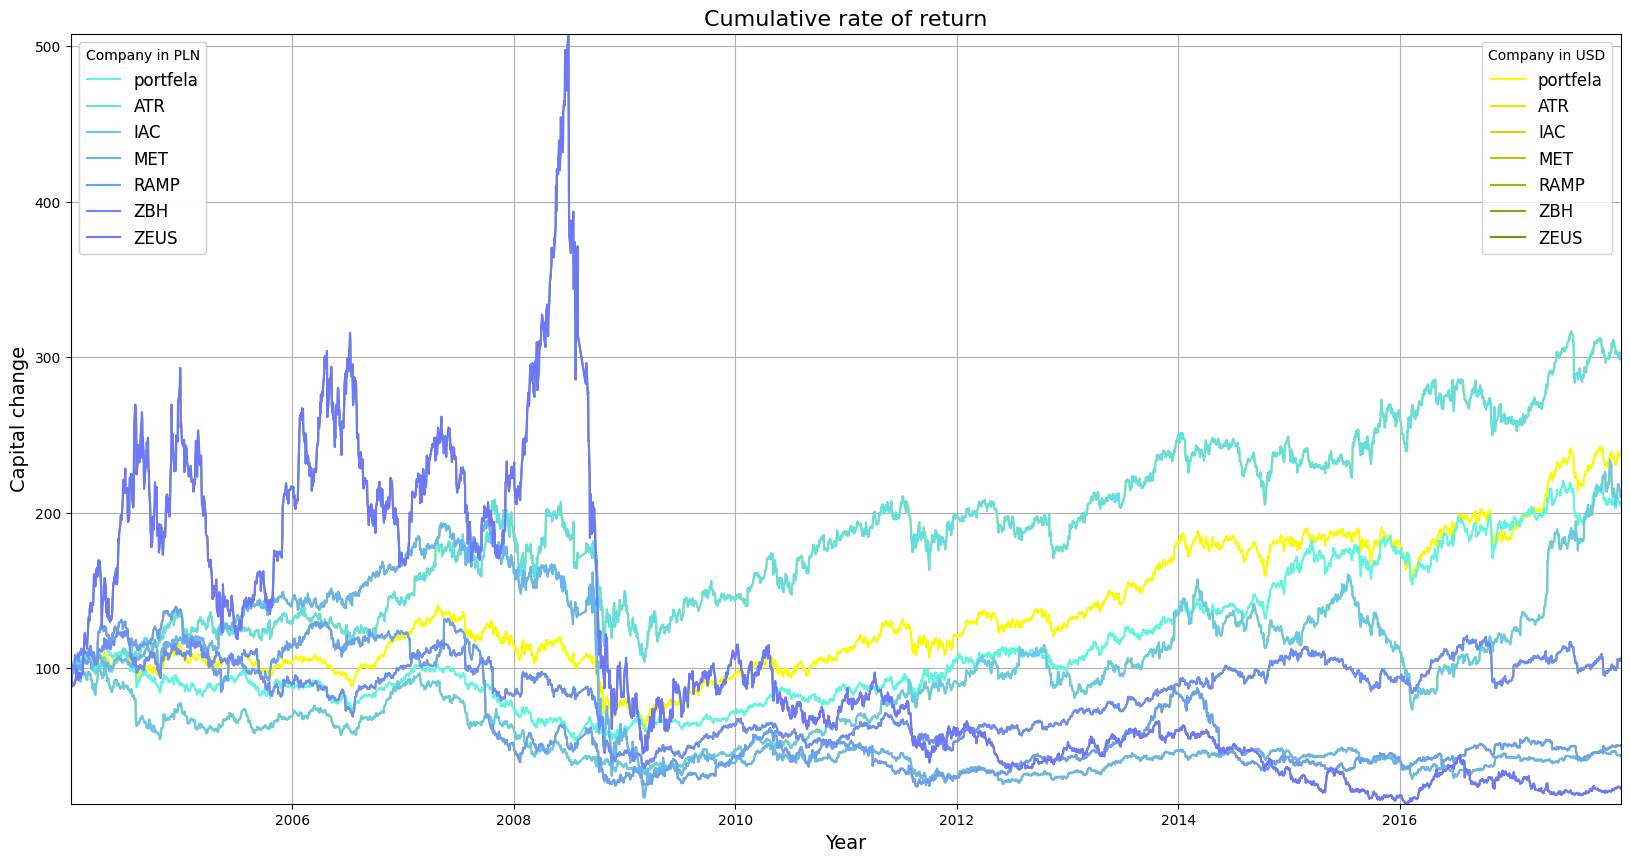

In [160]:
x = cumulative_rates_of_return["Date"]
y = ["CRoR portfela", "CRoR ATR", "CRoR IAC", "CRoR MET", "CRoR RAMP", "CRoR ZBH", "CRoR ZEUS"]
colors1 = ["#fafa00", "#e3e902", "#ccd904", "#b5c806", "#9eb708", "#87a70a", "#70960c"]
plt.figure(figsize=(20, 10))
plt.grid()

lines1 = []
for company in range(len(y)):
    line, = plt.plot(x, cumulative_rates_of_return[y[company]], label=y[company].replace("CRoR ", ""), color=colors1[company])
    lines1.append(line)

legend1 = plt.legend(lines1, [line.get_label() for line in lines1], title='Company in USD', loc=1, fontsize=12)

x2 = cumulative_rates_of_return_converted["Date"]

colors2 = ["#61f4de", "#63dfe4", "#65cbe9", "#68b6ef", "#6aa1f4", "#6c8dfa", "#6e78ff"]
lines2 = []
for company2 in range(len(y)):
    line, = plt.plot(x2, cumulative_rates_of_return_converted[y[company2]], label=y[company2].replace("CRoR ", ""),
                     color=colors2[company2])
    lines2.append(line)

legend2 = plt.legend(lines2, [line.get_label() for line in lines2], title='Company in PLN', loc=2, fontsize=12)

plt.xlabel("Year", fontsize=14)
plt.ylabel("Capital change", fontsize=14)
plt.title("Cumulative rate of return", fontsize=16)
plt.autoscale(enable=None, axis="x", tight=True)
plt.gca().add_artist(legend1)
plt.gca().add_artist(legend2)

# plt.savefig('wykres4.png',  bbox_inches='tight', pad_inches=0.1)
plt.show()


At first glance, the chart does not differ from the chart in the basic part, but the company data overlaps with each other so much that we are unable to see it. Below we present a chart with the data shifted on the y-axis by 10.

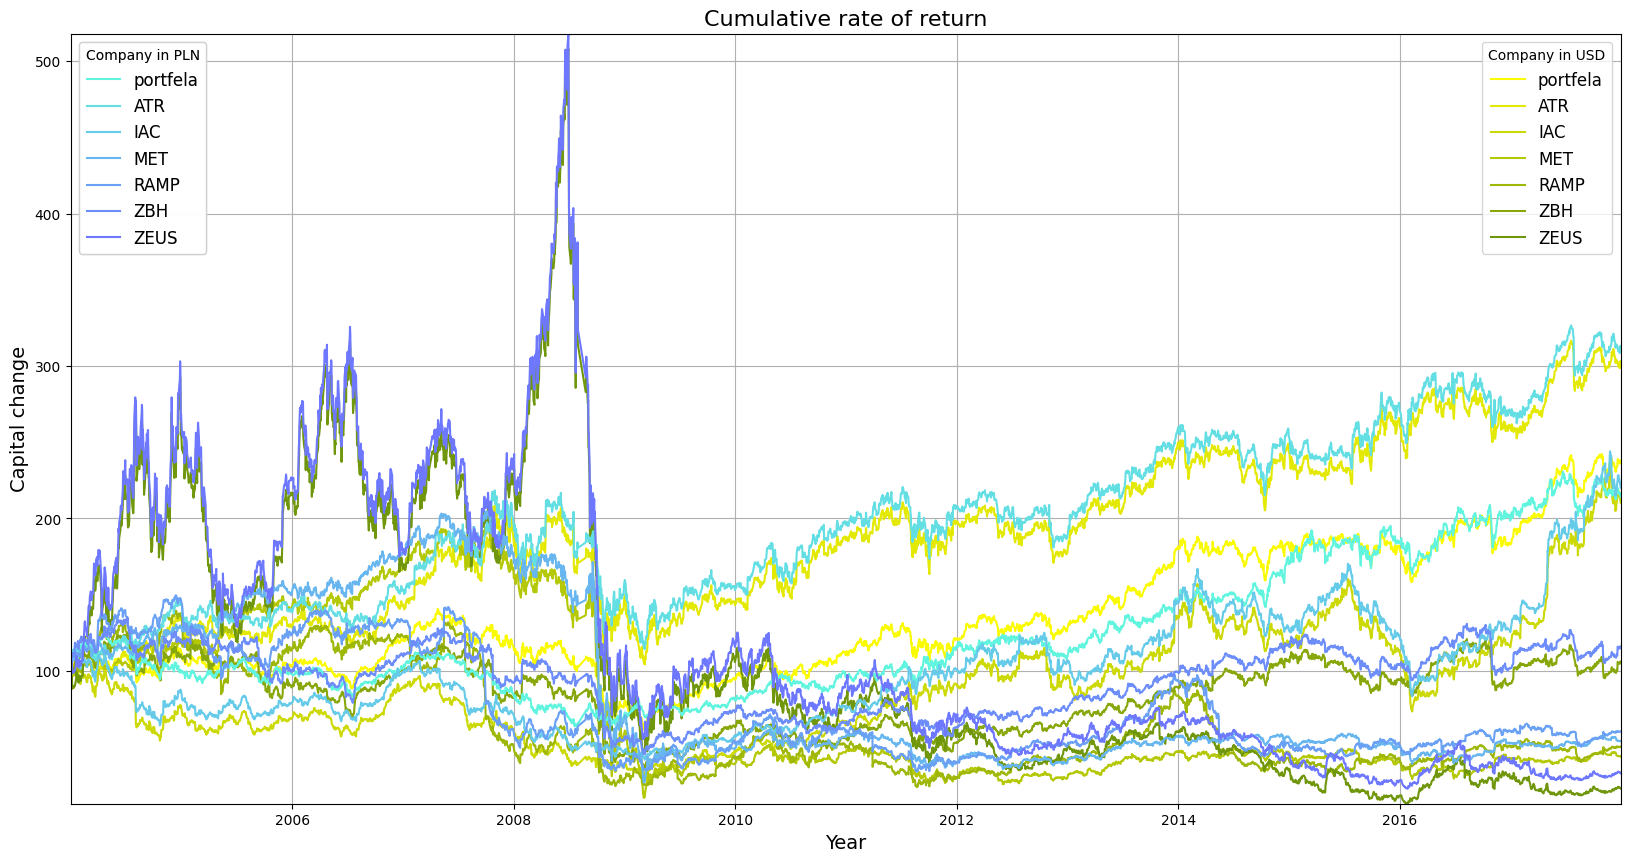

In [163]:
plt.figure(figsize=(20, 10))
plt.grid()

x = cumulative_rates_of_return["Date"]
y = ["CRoR portfela", "CRoR ATR", "CRoR IAC", "CRoR MET", "CRoR RAMP", "CRoR ZBH", "CRoR ZEUS"]
colors1 = ["#fafa00", "#e3e902", "#ccd904", "#b5c806", "#9eb708", "#87a70a", "#70960c"]
lines1 = []
for company in range(len(y)):
    line, = plt.plot(x, cumulative_rates_of_return[y[company]], label=y[company].replace("CRoR ", ""), color=colors1[company])
    lines1.append(line)
    
# We create two separate legends. One for data in dollars and one for zlotys.
legend1 = plt.legend(lines1, [line.get_label() for line in lines1], title='Company in USD', loc=1, fontsize=12)

x2 = cumulative_rates_of_return_converted["Date"]
colors = ["#61f4de", "#63dfe4", "#65cbe9", "#68b6ef", "#6aa1f4", "#6c8dfa", "#6e78ff"]
lines2 = []
for company2 in range(len(y)):
    offset = 10  
    line, = plt.plot(x2, cumulative_rates_of_return_converted[y[company2]] + offset,
                     label=y[company2].replace("CRoR ", ""), color=colors[company2])
    lines2.append(line)

legend2 = plt.legend(lines2, [line.get_label() for line in lines2], title='Company in PLN', loc=2, fontsize=12)

plt.xlabel("Year", fontsize=14)
plt.ylabel("Capital change", fontsize=14)
plt.title("Cumulative rate of return", fontsize=16)
plt.autoscale(enable=None, axis="x", tight=True)
# add both legends to the chart.
plt.gca().add_artist(legend1)
plt.gca().add_artist(legend2)
# plt.savefig('wykres5.png',  bbox_inches='tight', pad_inches=0.1)
plt.show()

We concluded that it would be better to present the data in separate graphs as we did below.

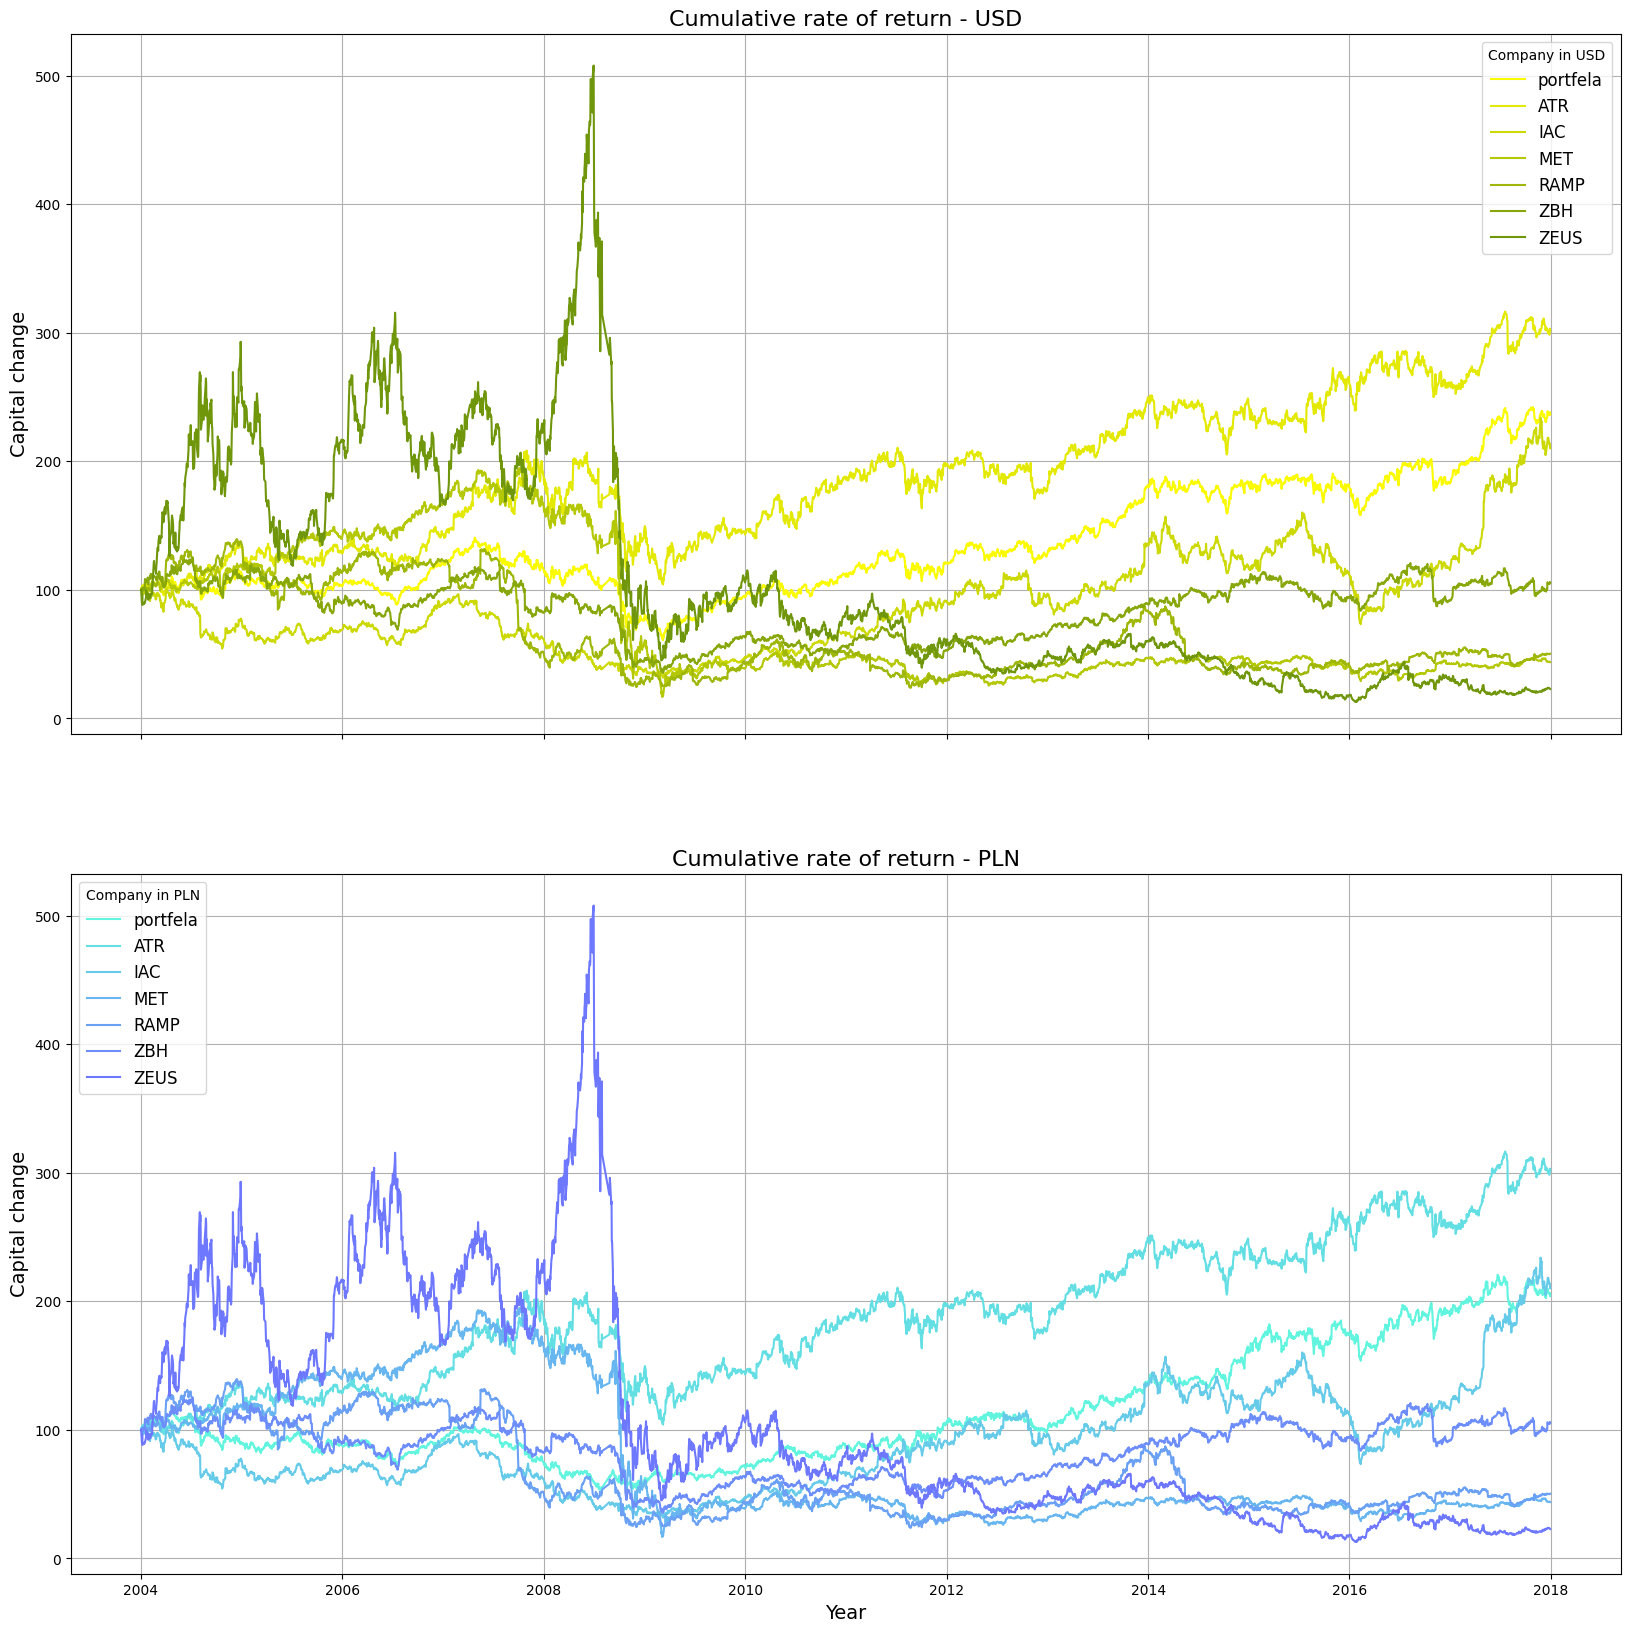

In [164]:
x = cumulative_rates_of_return["Date"]
y = ["CRoR portfela", "CRoR ATR", "CRoR IAC", "CRoR MET", "CRoR RAMP", "CRoR ZBH", "CRoR ZEUS"]
colors1 = ["#fafa00", "#e3e902", "#ccd904", "#b5c806", "#9eb708", "#87a70a", "#70960c"]
colors2 = ["#61f4de", "#63dfe4", "#65cbe9", "#68b6ef", "#6aa1f4", "#6c8dfa", "#6e78ff"]

fig, axs = plt.subplots(2, 1, figsize=(20, 20), sharex=True)

# first subplot
axs[0].grid()
lines1 = []
for company in range(len(y)):
    line, = axs[0].plot(x, cumulative_rates_of_return[y[company]], label=y[company].replace("CRoR ", ""), color=colors1[company])
    lines1.append(line)

axs[0].legend(lines1, [line.get_label() for line in lines1], title='Company in USD', loc=1, fontsize=12)

axs[0].set_ylabel("Capital change", fontsize=14)
axs[0].set_title("Cumulative rate of return - USD", fontsize=16)

# second subplot
axs[1].grid()
lines2 = []
for company2 in range(len(y)):
    line, = axs[1].plot(x, cumulative_rates_of_return_converted[y[company2]],
                       label=y[company2].replace("CRoR ", ""), color=colors2[company2])
    lines2.append(line)

axs[1].legend(lines2, [line.get_label() for line in lines2], title='Company in PLN', loc=2, fontsize=12)
axs[1].set_xlabel("Year", fontsize=14)
axs[1].set_ylabel("Capital change", fontsize=14)
axs[1].set_title("Cumulative rate of return - PLN", fontsize=16)
# plt.savefig('wykres4.png',  bbox_inches='tight', pad_inches=0.1)
plt.show()


The chart below presents a comparison for portfolios only.

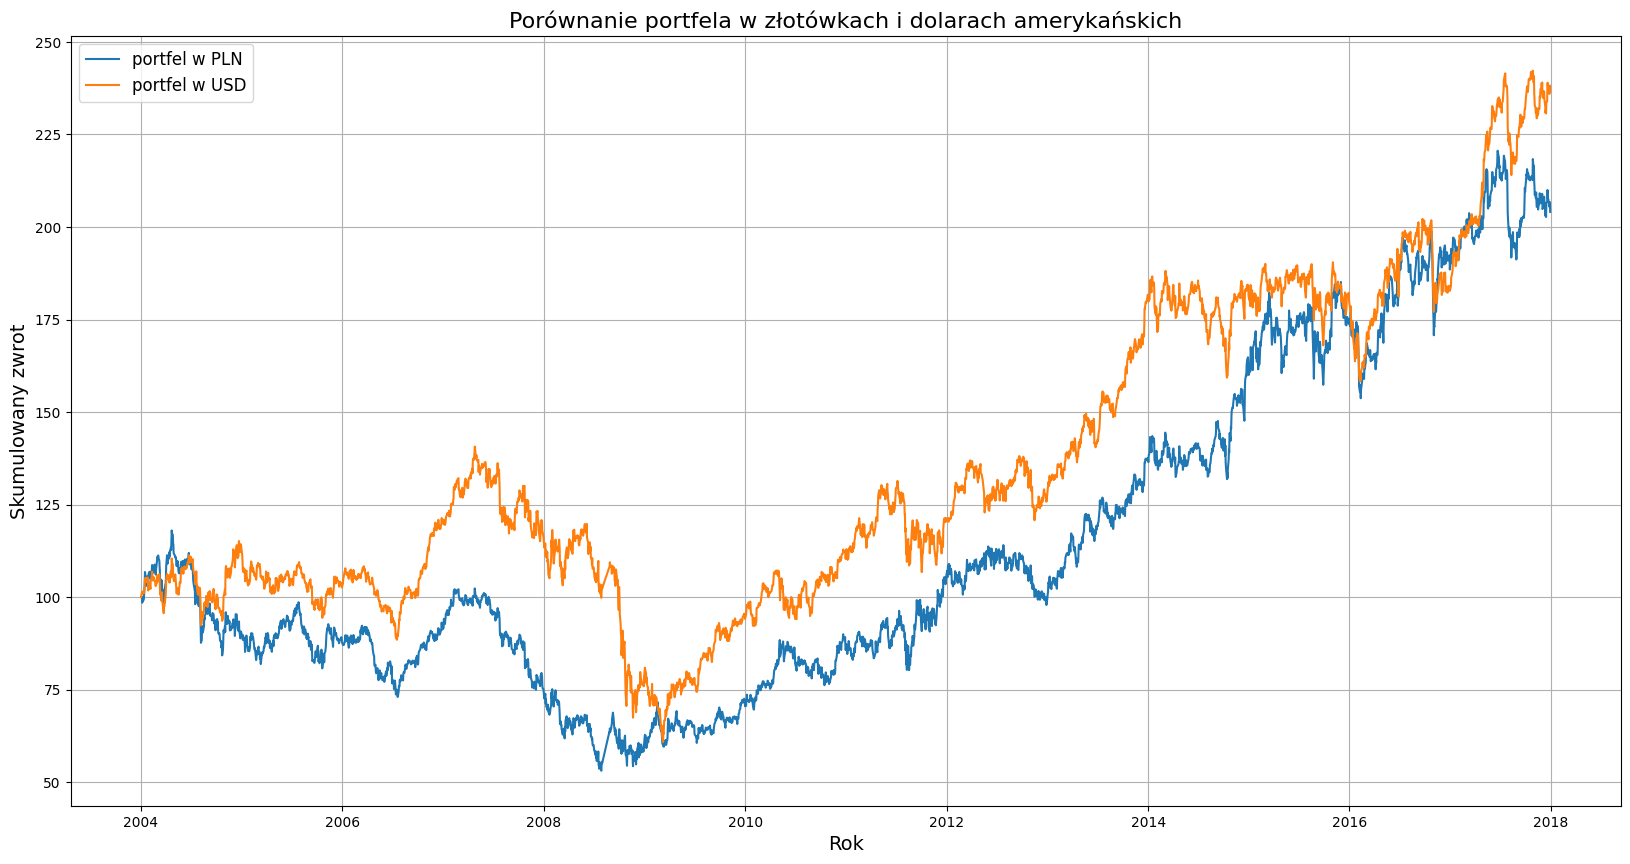

In [ ]:
plt.figure(figsize=(20,10))
plt.grid()
plt.plot(cumulative_rates_of_return["Date"], cumulative_rates_of_return_converted["CRoR portfela"], label="portfel w PLN")
plt.plot(cumulative_rates_of_return["Date"], cumulative_rates_of_return["CRoR portfela"], label="portfel w USD")

plt.xlabel('Rok', fontsize=14)
plt.ylabel('Cumulative return', fontsize=14)
plt.title('Comparison of the wallet in Polish zloty and US dollars', fontsize=16)
plt.legend(loc=2, fontsize=12)
plt.show()

## 7. Perform a simple simulation of your portfolio:
- assume that you have PLN 10,000,
- calculate how many shares of each company you can buy (take into account transaction costs),
- assume that the portfolio is static, i.e. you do not change the weight of individual companies in it,
- calculate the value of the portfolio over time, assuming that you bought the shares on the first day of trading, and that you can only buy full shares.

We choose the XTB brokerage house. The commission on the value of the share purchase is 0.5%

In [169]:
print("We present the data needed to conduct the simulation.\n")
print(f"Stock prices on the day {currency.iloc[0,0]} in USD: \n{company_data.iloc[0,1:].to_string()}")
print(f"\nUS dollar exchange rate {np.round(currency.iloc[0,1], 4)} zł in {currency.iloc[0,0]}.")

portfel = pd.Series(company_data.iloc[0,1:].values * currency.iloc[0,1:].values, company_data.columns.values[1:])
print(f"\nShare prices after conversion to zloty:\n{portfel.to_string()}")
print(f"\nWallet weights: \n{np.round(optimal_weights,6)}")


We present the data needed to conduct the simulation.

Stock prices on the day 2004-01-02 in USD: 
Ticker
ATR     19.280001
IAC      7.025336
MET     29.910873
RAMP    18.809999
ZBH     67.961166
ZEUS         8.11

US dollar exchange rate 3.7359 zł in 2004-01-02.

Share prices after conversion to zloty:
ATR      72.028153
IAC      26.245951
MET      111.74403
RAMP     70.272276
ZBH     253.896116
ZEUS     30.298147

Wallet weights: 
[0.423921 0.231136 0.       0.028185 0.316757 0.      ]


In [171]:
saldo = 10000
koszyk = np.array([])
docelowo_przeznaczamy = saldo * optimal_weights
print("_"*60)
print("The weights show how the funds were distributed:")
print(np.round(docelowo_przeznaczamy, 4))
print(f"sum = {sum(docelowo_przeznaczamy):.2f} zł")
print("_"*60)

symulacja = (docelowo_przeznaczamy // portfel).astype(int)
print("A basket simulation is taking place...")
print("_"*30)

print("Simulation results:")
print(symulacja.to_string())
print("_"*50)

saldo = saldo - sum(symulacja * portfel)
koszyk = symulacja.values
for i in range(np.size(koszyk)):
    print(f"Bought  {koszyk[i]} shares of the company {symulacja.index[i]} worth {koszyk[i]*portfel[i]:.2f} zł")
print("_"*80)

print(f"The total value of the basket is = {sum(koszyk * portfel):.2f} zł")
print(f"To this should be added 0.5% of transaction costs, i.e. {sum(koszyk * portfel):.2f} * 1.005 = {sum(koszyk * portfel) * 1.005:.2f} zł")
reszta = 10000 - sum(koszyk * portfel) * 1.005

print(f"The rest is left = {reszta:.2f} zł")
print("_"*30)


____________________________________________________________
The weights show how the funds were distributed:
[4239.213  2311.3619    0.      281.8525 3167.5726    0.    ]
sum = 10000.00 zł
____________________________________________________________
A basket simulation is taking place...
______________________________
Simulation results:
ATR     58
IAC     88
MET      0
RAMP     4
ZBH     12
ZEUS     0
__________________________________________________
Bought  58 shares of the company ATR worth 4177.63 zł
Bought  88 shares of the company IAC worth 2309.64 zł
Bought  0 shares of the company MET worth 0.00 zł
Bought  4 shares of the company RAMP worth 281.09 zł
Bought  12 shares of the company ZBH worth 3046.75 zł
Bought  0 shares of the company ZEUS worth 0.00 zł
________________________________________________________________________________
The total value of the basket is = 9815.12 zł
To this should be added 0.5% of transaction costs, i.e. 9815.12 * 1.005 = 9864.19 zł
The rest is le

C:\Users\Marcin\AppData\Local\Temp\ipykernel_11332\1090327592.py:21: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f"Bought  {koszyk[i]} shares of the company {symulacja.index[i]} worth {koszyk[i]*portfel[i]:.2f} zł")


## 8. Present a graph comparing the results of the simulation portfolio and the base portfolio.

We create a set of 14 data for the previously calculated annual portfolio return of approximately 8% (we assigned it to the variable `portfolio_return_rate`).

In [155]:
przedzialy = np.linspace(0, 3494, 14).astype(int)
zakladana_wartosc_portfela = 10000
zakladana_zmiana_portfela = []
symulowana_zmiana_portfela = []
daty = []

for i in range(np.size(przedzialy)):
    zakladana_wartosc_portfela *= (1 + portfolio_rate_of_return)
    zakladana_zmiana_portfela.append(zakladana_wartosc_portfela)
    daty.append(company_data["Date"].values[przedzialy[i]])
    symulowana_zmiana_portfela.append((sum((converted_stocks.iloc[przedzialy[i], 1:] * symulacja))))

In [172]:
symulowany_portfel = pd.DataFrame({
    "Date": daty,
    "Assumed portfolio value": zakladana_zmiana_portfela,
    "simulated portfolio value": symulowana_zmiana_portfela})
symulowany_portfel

,Date,Assumed portfolio value,simulated portfolio value
0,2004-01-02,10806.092641,9815.119108
1,2005-01-27,11677.163817,8870.125080
2,2006-02-23,12618.451399,9352.859965
3,2007-03-21,13635.615481,10675.390870
4,2008-04-21,14734.772411,8374.895996
5,2009-06-10,15922.531572,8953.007754
6,2010-07-06,17206.035125,10636.580273
7,2011-07-29,18593.000955,12588.539659
8,2012-08-22,20091.769080,15431.489583
9,2013-09-18,21711.351800,17642.099474


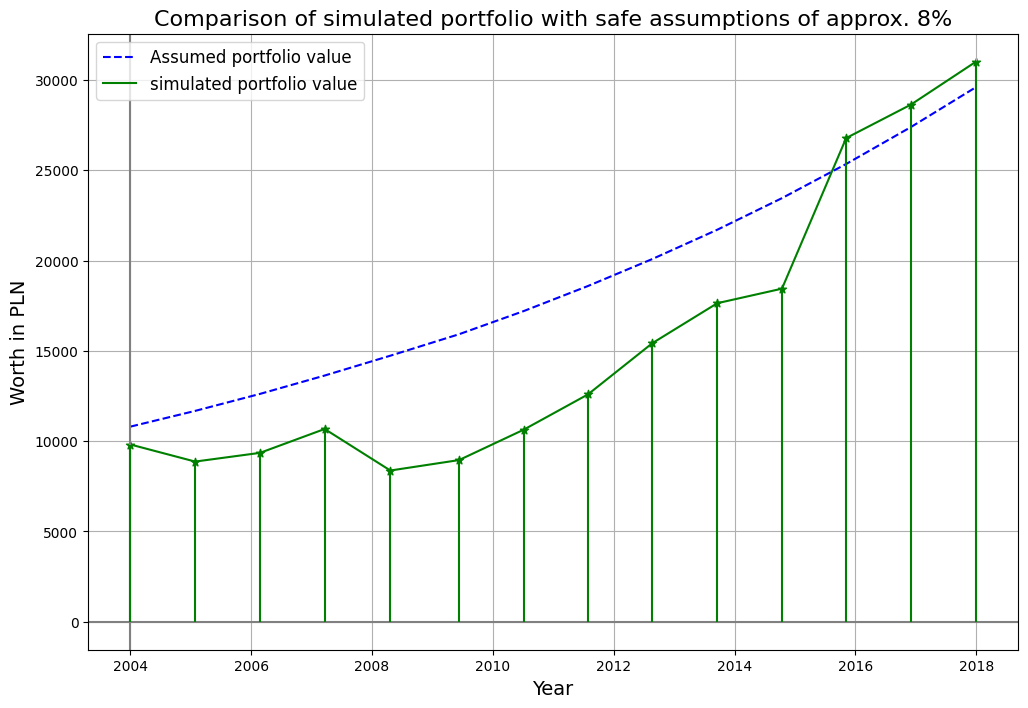

In [175]:
osx = symulowany_portfel["Date"]
osy1 = symulowany_portfel["Assumed portfolio value"].values
osy2 = symulowany_portfel["simulated portfolio value"].values
plt.figure(figsize=(12, 8))
plt.grid()
plt.plot(osx, osy1, label="Assumed portfolio value", color="blue", linestyle="--")
plt.plot(osx, osy2, label="simulated portfolio value", color="green")
plt.scatter(osx, symulowana_zmiana_portfela, color="green", marker="*")
plt.axvline(x=symulowany_portfel["Date"][0], c="grey")
plt.axhline(y=0, c="grey")
plt.vlines(x=symulowany_portfel["Date"], ymin=0, ymax=symulowany_portfel["simulated portfolio value"].values, color="green")
plt.legend(loc=2, fontsize=12)
plt.xlabel("Year", fontsize=14)
plt.ylabel("Worth in PLN", fontsize=14)
plt.title("Comparison of simulated portfolio with safe assumptions of approx. 8%", fontsize=16)
plt.show()

#### Conclusions
According to the adopted assumptions, our simulated portfolio exceeded the threshold of 8% portfolio return rate.

## 9. Show a graph comparing the weightings of individual companies in the simulated portfolio

[Text(0.5, 0, 'company'),
 Text(0, 0.5, 'percent %'),
 Text(0.5, 1.0, 'Distribution of weights between company shares')]

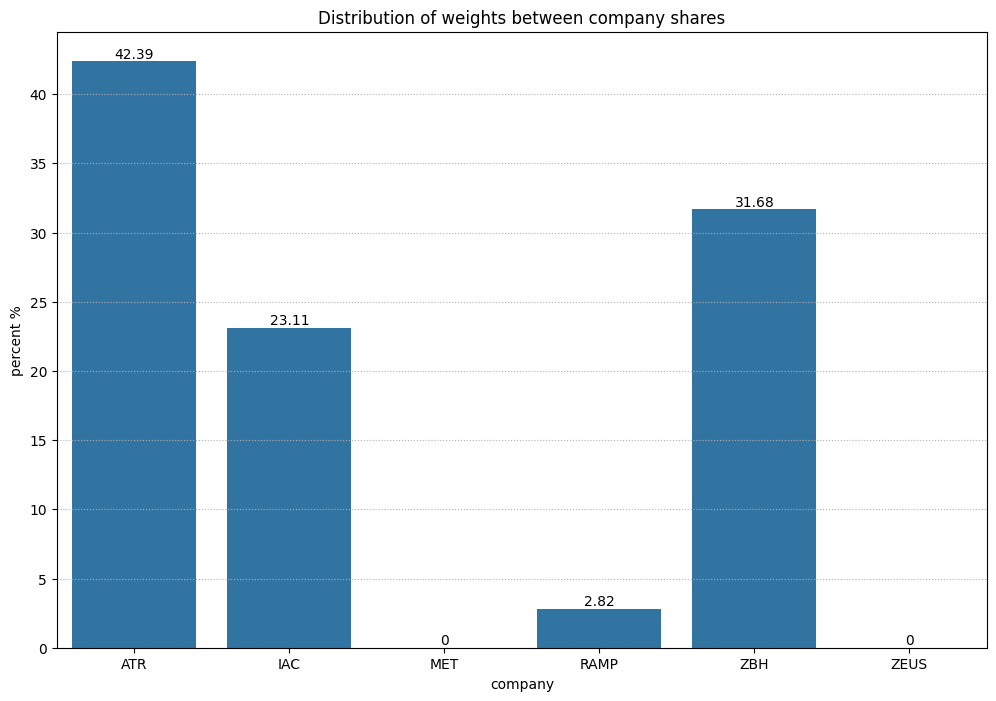

In [176]:
fig, ax = plt.subplots(figsize=(12, 8))
plt.grid(linestyle=':')
sns.barplot(x=symulacja.index, y=np.round(optimal_weights*100,2), ax=ax)
ax.bar_label(ax.containers[0], label_type='edge')
ax.set(xlabel="company", ylabel="percent %", title="Distribution of weights between company shares")